# Gliderpy

gliderpy builds off of the functionality of erddapy to make glider data access, manipulation, and visualization even simpler 

(https://github.com/oceanhackweek/ohw20-proj-glide-data-fetcher) 

# Here is an example of plain erddapy

Copied from the [errdapy intro](https://ioos.github.io/erddapy/quick_intro-output.html#Longer-introduction)

Erddapy is great but we want to try to make it even more simple with fewer lines of code with our **gliderpy** package

In [24]:
from erddapy import ERDDAP


e = ERDDAP(
    server="https://gliders.ioos.us/erddap",
    protocol="tabledap",
    response="csv",
)
e.dataset_id = "whoi_406-20160902T1700"

e.variables = [
    "depth",
    "latitude",
    "longitude",
    "salinity",
    "temperature",
    "time",
]

e.constraints = {
    "time>=": "2016-07-10T00:00:00Z",
    "time<=": "2017-02-10T00:00:00Z",
    "latitude>=": 38.0,
    "latitude<=": 41.0,
    "longitude>=": -72.0,
    "longitude<=": -69.0,
}


In [25]:
df = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
)
df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-03 20:15:46+00:00,5.35,40.990881,-71.12439,32.245422,20.6620
2016-09-03 20:15:46+00:00,6.09,40.990881,-71.12439,32.223183,20.6512
2016-09-03 20:15:46+00:00,6.72,40.990881,-71.12439,32.237950,20.6047
2016-09-03 20:15:46+00:00,7.37,40.990881,-71.12439,32.235470,20.5843
2016-09-03 20:15:46+00:00,8.43,40.990881,-71.12439,32.224503,20.5691


# Fetch glider data using glider ID
Emulating the UI of [argopy](https://github.com/euroargodev/argopy)

In [23]:
#from gliderpy.fetchers import GliderDataFetcher

glider_grab = GliderDataFetcher()

glider_grab.fetcher.dataset_id = "whoi_406-20160902T1700"
df = glider_grab.to_pandas()
df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-02 17:05:38+00:00,6.43,41.120018,-71.017118,32.079258,20.5407
2016-09-02 17:05:38+00:00,7.82,41.120018,-71.017118,32.095406,20.5071
2016-09-02 17:05:38+00:00,8.69,41.120018,-71.017118,32.111920,20.4904
2016-09-02 17:05:38+00:00,9.54,41.120018,-71.017118,32.126587,20.4897
2016-09-02 17:05:38+00:00,10.32,41.120018,-71.017118,32.140717,20.4909


Try with a different dataset

In [24]:
glider_grab = GliderDataFetcher()
glider_grab.fetcher.dataset_id = "sp022-20170209T1616"

df = glider_grab.to_pandas()
df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2017-02-09 17:44:45+00:00,0.000000,25.77845,-80.03365,NaN,NaN
2017-02-09 17:44:45+00:00,103.299385,25.77845,-80.03365,35.982,18.032
2017-02-09 17:44:45+00:00,102.187210,25.77845,-80.03365,36.000,18.274
2017-02-09 17:44:45+00:00,101.194190,25.77845,-80.03365,36.073,19.066
2017-02-09 17:44:45+00:00,100.161446,25.77845,-80.03365,36.155,20.375


# Now we will pass time and space constraints
We can make a direct call to erddapy's `constraints'

In [25]:
glider_grab = GliderDataFetcher()

glider_grab.fetcher.dataset_id = "whoi_406-20160902T1700"

glider_grab.fetcher.constraints = {
    "time>=": "2016-07-10T00:00:00Z",
    "time<=": "2016-09-15T00:00:00Z",
    "latitude>=": 38.0,
    "latitude<=": 41.0,
    "longitude>=": -72.0,
    "longitude<=": -69.0,
}

df = glider_grab.to_pandas()
df.tail()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-14 23:44:32+00:00,6.32,40.525497,-70.701245,33.610584,20.5324
2016-09-14 23:44:32+00:00,5.82,40.525497,-70.701245,33.302277,20.3212
2016-09-14 23:44:32+00:00,5.31,40.525497,-70.701245,33.191547,20.2575
2016-09-14 23:44:32+00:00,4.82,40.525497,-70.701245,33.163350,20.2238
2016-09-14 23:44:32+00:00,4.16,40.525497,-70.701245,33.141460,20.2059


Let's try making a method of the class to do this more neatly

In [33]:
glider_grab = GliderDataFetcher()

# In this case we don't want to specify a dataset_id, we want all gliders in that query.
glider_grab.fetcher.dataset_id = "whoi_406-20160902T1700"
min_lat, max_lat, min_lon, max_lon = 10, 40.5, -71, 180
start_time, end_time = "2016-08-1","2016-09-18"
glider_grab.query(
    min_lat,
    max_lat,
    min_lon,
    max_lon,
    start_time,
    end_time
)

df = glider_grab.to_pandas()
df.tail()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2016-09-14 19:47:17+00:00,6.55,40.4852,-70.725977,33.753006,20.6421
2016-09-14 19:47:17+00:00,6.08,40.4852,-70.725977,33.700924,20.6298
2016-09-14 19:47:17+00:00,5.31,40.4852,-70.725977,33.303110,20.3098
2016-09-14 19:47:17+00:00,4.78,40.4852,-70.725977,33.206260,20.2528
2016-09-14 19:47:17+00:00,4.27,40.4852,-70.725977,33.144120,20.2475


In [ ]:
df.describe()

How to ind glider datasets on server

Calling get_ids from the class searches for all databases tagged as glider

In [ ]:
from gliderpy.fetchers import DatasetList

datasets = DatasetList()
datasets.get_ids()

Let's look for the ones from UW

In [ ]:
datasets = DatasetList()
datasets.search_terms = ["UW"]
uw_glider_ids = datasets.get_ids()
uw_glider_ids

We'll pass that id back into our original data fetcher

In [ ]:
uw_grab = GliderDataFetcher()
uw_grab.fetcher.dataset_id = uw_glider_ids[18]

df = uw_grab.to_pandas(
)
df.head()

## Now let's plot the track map for a dataset

In [ ]:
glider_grab.plot_track()

## Now the transect for a given variable in that dataset

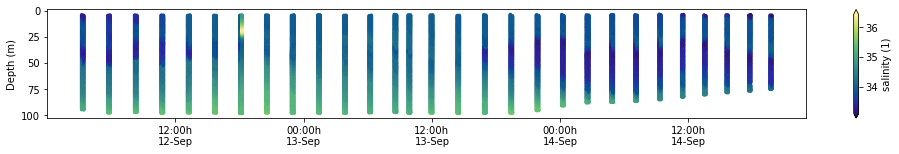

In [40]:
#Variable options: salinity (1) or temperature (Celcius).. this is a work in progress
glider_grab.plot_transect("salinity (1)")